# Leveraging Video-On-Demand streaming data for early forecast of a movie's success using Gradient Boosting Machines and advanced feature engineering techniques.
## Introduction

- **Objective:** To create a decision support system for aiding movie investments in the early stages of a movie's production.
- **Approach:** The system predicts movie success using a streaming rank scoring measure, leveraging historical data from various sources.
- **Data Utilization:** The model uses data available at the early stage of a movie's production, focusing on features that can be determined before or during the planning phase.

The goal of this project is to create a decision support system to aid movie investments at the early stage of a movie's production. The system predicts the success of a movie based on a streaming rank scoring measure by leveraging historical data from various sources. Using social network analysis and advanced natural language processing (NLP) techniques, the system automatically extracts several groups of features, including the “who” (cast and crew), the “what” (the plot)), as well as “hybrid” features that match “who” with “what”. In order to support investment decisions on a movie, the model has to be provided information that is available at the very early stage of the movie’s production. Consequently, our prediction of movie success can only leverage data that is available when a movie is still being planned. Predictions that are made right before or after the official release may have more data to use and get more accurate results, but they are too late for investors to make any meaningful decision.

# Setup and Libraries
**Python Libraries:** The project uses libraries like `pandas`, `networkx` for graph analyses, `sklearn` for machine learning tasks, and `lightgbm` for the prediction model.


In [1]:
import pandas as pd
from random import choice
import networkx as nx # Graph analyses
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import lightgbm as lgb # Prediction model
from utils import *
import matplotlib.pyplot as plt
import warnings

# Turn off the warnings
warnings.filterwarnings('ignore')

# Set the plt style to "ggplot"
plt.style.use('ggplot')

data_path = './data/'
countries = ['Mexico', 'Brazil', 'United States'] # Can be expanded to other countries

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alejandroleda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Loading and Preparation
- **Data Sources:** The data includes movie details, titles, and talent information.
- **Focus on Specific Regions:** Initially, the analysis focuses on movies in Mexico, but it can be expanded to other countries.

### Training Set

In [2]:
main_df = pd.read_pickle(data_path + 'netflixmoviemain_df.pkl')

titles = pd.read_pickle(data_path + 'titles.pkl')
talent = pd.read_pickle(data_path + 'talent.pkl')
talent = talent.merge(titles[['jw_entity_id', 'original_release_year', 'genre_1']], on='jw_entity_id', how='left')

main_df

,country,jw_entity_id,rank,is_nflx_original,score,date,age_certification,object_type,original_release_year,original_title,...,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12
0,Argentina,tm1000599,NaN,None,1.0,2021-11-07,None,movie,2021.0,A Última Floresta,...,None,None,None,None,None,None,None,None,None,None
1,Argentina,tm1000619,NaN,None,1.0,2022-05-07,None,movie,2022.0,రాధే శ్యామ్,...,None,None,None,None,None,None,None,None,None,None
2,Argentina,tm1001097,NaN,None,1.0,2022-06-29,R,movie,2022.0,Beauty,...,romance,None,None,None,None,None,None,None,None,None
3,Argentina,tm1001912,NaN,None,1.0,2022-03-02,None,movie,2021.0,Trust,...,romance,None,None,None,None,None,None,None,None,None
4,Argentina,tm1003034,NaN,None,1.0,2021-08-23,None,movie,2021.0,The Witcher: Nightmare of the Wolf,...,scifi,animation,action,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25831,Venezuela,tm996762,NaN,None,1.0,2022-07-07,None,movie,2022.0,మేజర్,...,None,None,None,None,None,None,None,None,None,None
25832,Venezuela,tm998033,NaN,None,1.0,2021-11-18,None,movie,2021.0,டாக்டர்,...,comedy,crime,None,None,None,None,None,None,None,None
25833,Venezuela,tm998992,NaN,None,1.0,2022-09-07,PG,movie,2021.0,竜とそばかすの姫,...,fantasy,music,scifi,None,None,None,None,None,None,None
25834,Venezuela,tm999817,NaN,None,1.0,2021-12-01,None,movie,2021.0,白蛇 II：青蛇劫起,...,action,None,None,None,None,None,None,None,None,None


# Feature Engineering
- **Talent Metrics:** Metrics include total and average scores by actors, directors, and producers for each film.
- **Tenure**: Calculating the experience of talents in the industry. Reflects how much experience she/he may have in the industry. It is calculated as the time difference (in days) between the movie in which a talent most recently appeared and that in which he/she first ever appeared. For each movie, we will calculate the average tenure for its actors, directors and producers.
- **Network Analysis:** Using NetworkX to analyze social networks of talents based on their collaborations in films.

The general purpose is to extract and aggregate metrics from observations that include a list of participating members, such as a list of actors, directors and producers from a film. The metrics extracted include metrics by member which are then aggregated for all members in an observation (Ex. total and average score by actor for all actors in a film), and network analysis (such as degree centrality measures).

In [3]:
# Create a feature called 'tenure' to measure the number of years between the earliest movie and the latest movie of each talent
talent['tenure'] = talent.groupby('person_id')['original_release_year'].transform(lambda x: x.max() - x.min())
talent

,role,character_name,person_id,name,title,jw_entity_id,original_release_year,genre_1,tenure
0,ACTOR,Janaki,68294,Meena,Avvai Shanmugi,tm110160,1996.0,drama,35.0
1,ACTOR,Joseph,145348,Nagesh,Avvai Shanmugi,tm110160,1996.0,drama,46.0
2,ACTOR,Bhai,45436,Nassar,Avvai Shanmugi,tm110160,1996.0,drama,35.0
3,ACTOR,Rathna,432833,Heera Rajgopal,Avvai Shanmugi,tm110160,1996.0,drama,6.0
4,ACTOR,Kousi,471253,Rani,Avvai Shanmugi,tm110160,1996.0,drama,6.0
...,...,...,...,...,...,...,...,...,...
959963,EDITOR,None,15210,Larry Bock,Remember the Daze,tm73324,2008.0,comedy,30.0
959964,EXECUTIVE_PRODUCER,None,618188,Kevin Loughery,Remember the Daze,tm73324,2008.0,comedy,1.0
959965,ORIGINAL_MUSIC_COMPOSER,None,33249,Dustin O'Halloran,Remember the Daze,tm73324,2008.0,comedy,14.0
959966,PRODUCER,None,17275,Matthew Rhodes,Remember the Daze,tm73324,2008.0,comedy,16.0


## Network Analysis
Any network with connections between individuals, where the connections capture the relationship between them is a social network. Analyzing these networks can give us great insight about the people in the network like who are real influencers, who are most connected, etc.

Each network consists of:

- **Nodes**: The individuals whose network we are building. Talent in this case.
- **Edges**: The connection between the nodes. It represents a relationship between the nodes of the network. In this case, the relationship are the films that talent have worked together.

For the purpose of network analysis we leverage the powerful `NetworkX` library.

To the end goal of finding the most important nodes (individuals) in the network, we will focus on two metrics knows as **centrality measures**.

In [4]:
local_df, local_talent = get_country_dfs('Mexico', main_df, talent)
colab_matrix = get_colab_matrix(local_df, local_talent)
G, talent_centrality_measures = graph(colab_matrix)

local_talent.drop(columns=['character_name', 'original_release_year', 'genre_1', 'score'], inplace=True)
local_talent.drop_duplicates(inplace=True)

# Group by 'person_id' and 'role' and take the first value of the rest of the columns
local_talent = local_talent.groupby(['person_id', 'role']).first().reset_index()

local_talent = local_talent.merge(talent_centrality_measures, on='person_id', how='left')

local_talent = local_talent.fillna(0)

# Group by 'jw_entity_id' and 'role' and take the mean of the rest of the columns
local_talent_title_agg = local_talent.drop(columns=['person_id', 'name', 'title']).groupby(['jw_entity_id', 'role']).mean().reset_index()

# Pivot the table to have 'jw_entity_id' as index, 'role' as columns and the rest of the columns as values
local_talent_title_agg = local_talent_title_agg.pivot(index='jw_entity_id', columns='role').reset_index()
local_talent_title_agg.columns = ['_'.join(col) for col in local_talent_title_agg.columns.values]
local_talent_title_agg.rename(columns={'jw_entity_id_': 'jw_entity_id'}, inplace=True)

# Merge the 'local_df' with the 'local_talent_title_agg' table on 'jw_entity_id'
local_df = local_df.merge(local_talent_title_agg, on='jw_entity_id', how='left')
local_df

,country,jw_entity_id,rank,is_nflx_original,score,date,age_certification,object_type,original_release_year,original_title,...,prank_cent_EDITOR,prank_cent_EXECUTIVE_PRODUCER,prank_cent_MUSIC,prank_cent_ORIGINAL_MUSIC_COMPOSER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_SONGS,prank_cent_VISUAL_EFFECTS,prank_cent_WRITER
0,Mexico,tm1000037,NaN,None,1.0,2021-09-23,R,movie,2021.0,Je suis Karl,...,0.000053,NaN,0.000029,NaN,0.000029,0.000053,NaN,NaN,NaN,0.000029
1,Mexico,tm1000599,NaN,None,1.0,2021-11-07,None,movie,2021.0,A Última Floresta,...,0.000036,NaN,NaN,0.000036,0.000037,NaN,NaN,NaN,NaN,0.000039
2,Mexico,tm1000619,NaN,None,1.0,2022-05-06,None,movie,2022.0,రాధే శ్యామ్,...,0.000032,NaN,NaN,0.000032,0.000032,0.000032,NaN,NaN,NaN,0.000033
3,Mexico,tm1001097,NaN,None,1.0,2022-06-29,R,movie,2022.0,Beauty,...,0.000026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000050
4,Mexico,tm1002815,NaN,None,1.0,2021-09-15,None,movie,2021.0,Nightbooks,...,0.000045,0.000024,NaN,NaN,0.000074,0.000024,0.000045,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,Mexico,tm996762,NaN,None,1.0,2022-07-07,None,movie,2022.0,మేజర్,...,0.000029,0.000029,NaN,0.000029,0.000029,0.000059,0.000031,NaN,NaN,NaN
977,Mexico,tm998188,NaN,None,1.0,2021-12-01,None,movie,2021.0,Donde caben dos,...,NaN,NaN,NaN,NaN,0.000033,NaN,NaN,NaN,NaN,0.000046
978,Mexico,tm998992,NaN,None,1.0,2022-09-07,PG,movie,2021.0,竜とそばかすの姫,...,0.000033,0.000041,NaN,0.000033,0.000033,0.000033,0.000034,0.000033,NaN,NaN
979,Mexico,tm999817,NaN,None,1.0,2021-12-01,None,movie,2021.0,白蛇 II：青蛇劫起,...,NaN,NaN,NaN,NaN,0.000037,NaN,NaN,NaN,NaN,0.000037


## Plot scoring
Another natural and important indicator of a movie’s performance is what the movie is about. Such information is usually available with high certainty in the development stage. To reflect what a movie is about, the content features in our model include both meta features, such as genre (e.g., action, sci-fi, family) and rating (e.g., PG13, and R), but also fine-grained description of a movie’s content – its plot synopsis. 

To get a better picture of what a plot is about we leverage the powerful **TextRank4Keyword** (`t4k`) library, which in turn is based on the **PageRank** library developed by Google. The input for `t4k` is a textual corpus from plot synopses and the output is a group of topics, each being represented by a probabilistic distribution over words. Those words with high probabilities on a topic are considered representative keywords for the plot. In turn each of this probabilities is the weighted against the movie's score. As a result, the weight of the resulting keywords are representative of the popularity of topics.

In [5]:
# create a pandas series called 'plots' with the index as the movie's 'jw_entity_id' and the value as the movie's 'short_description'
plots = pd.Series(main_df['short_description'].values, index=main_df['jw_entity_id'])

# drop duplicate index vales from the plots series
plots = plots[~plots.index.duplicated(keep='first')]

# Drop null values from the plots series
plots.dropna(inplace=True)

scored_keywords = score_keywords(plots, main_df)
# Create a dataframe called 'scored_plots' with the 'node_weight_scored_by_keyword_and_country' column summed by 'jw_entity_id' and 'country'
scored_plots = scored_keywords.groupby(['jw_entity_id', 'country'])['node_weight_scored_by_keyword_and_country'].sum().reset_index()

# Merge the 'local_df' with the 'scored_plots' table on 'jw_entity_id' and 'country'
local_df = local_df.merge(scored_plots, on=['jw_entity_id', 'country'], how='left')
local_df.rename(columns={'node_weight_scored_by_keyword_and_country': 'plot_score'}, inplace=True)
local_df

0it [00:00, ?it/s]

Extracting keywords from the plot of each of 4124 movies...


4124it [00:55, 74.23it/s]


Total number of keywords extracted: 41148


,country,jw_entity_id,rank,is_nflx_original,score,date,age_certification,object_type,original_release_year,original_title,...,prank_cent_EXECUTIVE_PRODUCER,prank_cent_MUSIC,prank_cent_ORIGINAL_MUSIC_COMPOSER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_SONGS,prank_cent_VISUAL_EFFECTS,prank_cent_WRITER,plot_score
0,Mexico,tm1000037,NaN,None,1.0,2021-09-23,R,movie,2021.0,Je suis Karl,...,NaN,0.000029,NaN,0.000029,0.000053,NaN,NaN,NaN,0.000029,87.920444
1,Mexico,tm1000599,NaN,None,1.0,2021-11-07,None,movie,2021.0,A Última Floresta,...,NaN,NaN,0.000036,0.000037,NaN,NaN,NaN,NaN,0.000039,1.724854
2,Mexico,tm1000619,NaN,None,1.0,2022-05-06,None,movie,2022.0,రాధే శ్యామ్,...,NaN,NaN,0.000032,0.000032,0.000032,NaN,NaN,NaN,0.000033,152.159986
3,Mexico,tm1001097,NaN,None,1.0,2022-06-29,R,movie,2022.0,Beauty,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000050,132.204779
4,Mexico,tm1002815,NaN,None,1.0,2021-09-15,None,movie,2021.0,Nightbooks,...,0.000024,NaN,NaN,0.000074,0.000024,0.000045,NaN,NaN,NaN,70.232126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,Mexico,tm996762,NaN,None,1.0,2022-07-07,None,movie,2022.0,మేజర్,...,0.000029,NaN,0.000029,0.000029,0.000059,0.000031,NaN,NaN,NaN,59.574578
977,Mexico,tm998188,NaN,None,1.0,2021-12-01,None,movie,2021.0,Donde caben dos,...,NaN,NaN,NaN,0.000033,NaN,NaN,NaN,NaN,0.000046,112.367622
978,Mexico,tm998992,NaN,None,1.0,2022-09-07,PG,movie,2021.0,竜とそばかすの姫,...,0.000041,NaN,0.000033,0.000033,0.000033,0.000034,0.000033,NaN,NaN,430.400154
979,Mexico,tm999817,NaN,None,1.0,2021-12-01,None,movie,2021.0,白蛇 II：青蛇劫起,...,NaN,NaN,NaN,0.000037,NaN,NaN,NaN,NaN,0.000037,78.210410


### Prediction Set Preparation

In [6]:
pred_set = pd.read_csv(data_path + 'project_form - movie.csv')

# make all column names lowercase
pred_set.columns = map(str.lower, pred_set.columns)

mask = ~pred_set['title'].isna()
pred_set['title'] = pred_set['title'].ffill()

# Create a 'pred_set_talent' dataframe that contains only the 'title', 'name', and 'role' columns
pred_set_talent = pred_set[['title', 'name', 'role']]

pred_set_talent.dropna(inplace=True)
pred_metadata = pred_set_talent.groupby(['title', 'role'])[['name']].agg(lambda x: ', '.join(x)).unstack().reset_index()
pred_metadata.dropna(axis=1, how='all', inplace=True)
pred_metadata.columns = [col[1] for col in pred_metadata.columns.values]
pred_metadata.rename(columns={'': 'title'}, inplace=True)

local_talent_crew_agg = local_talent.drop(columns=['person_id', 'title', 'jw_entity_id']).drop_duplicates()
local_talent_crew_agg = local_talent_crew_agg.groupby(['name', 'role']).mean().reset_index()

# Merge the 'pred_set_talent' dataframe with the 'local_talent' dataframe on the 'name' column
pred_set_talent = pred_set_talent.merge(local_talent_crew_agg, on=['name', 'role'], how='left')

pred_set_talent = pred_set_talent.drop(columns=['name']).groupby(['title', 'role']).mean().reset_index()

# Pivot the table to have 'title' as index, 'role' as columns and the rest of the columns as values
pred_set_talent = pred_set_talent.pivot(index='title', columns='role').reset_index()
pred_set_talent.columns = ['_'.join(col) for col in pred_set_talent.columns.values]
pred_set_talent.rename(columns={'title_': 'title'}, inplace=True)

pred_set = pred_set[mask].drop(columns=['name', 'role'])

# Drop rows with missing values for 'plot'
pred_set = pred_set.dropna(subset=['plot'])

# Merge the 'pred_set' dataframe with the 'pred_set_talent' dataframe on the 'title' column
pred_set = pred_set.merge(pred_set_talent, on='title', how='left')

# Create a pandas series called 'pred_set_plots' with the index as the movie's 'title' and the value as the movie's 'plot'
pred_set_plots = pd.Series(pred_set['plot'].values, index=pred_set['title'])
pred_set_keywords = extract_keywords(pred_set_plots)
pred_set_keywords.rename(columns={'jw_entity_id':'title'}, inplace=True)

# Create a dataframe called 'pred_set_keywords_scored' which is the inner merge of 'pred_set_keywords' and 'scored_keywords' on 'keyword'
pred_set_keywords_scored = pred_set_keywords.drop('node_weight', axis=1).merge(scored_keywords[['keyword', 'country', 'node_weight_scored_by_keyword_and_country']], on=['keyword'], how='inner')
pred_set_keywords_scored['node_weight_scored_by_keyword_and_country'] = pred_set_keywords_scored['node_weight_scored_by_keyword_and_country'] * pred_set_keywords_scored['node_weight_normalized']
pred_set_keywords_scored.drop(columns=['node_weight_normalized'], inplace=True)
pred_set_keywords_scored.drop_duplicates(inplace=True)

# Create a dataframe called 'pred_set_plots_scored' which is the sum of 'node_weight_scored_by_keyword_and_country' grouped by 'title' and 'country'
pred_set_plots_scored = pred_set_keywords_scored.groupby(['title', 'country'])['node_weight_scored_by_keyword_and_country'].sum().reset_index()

pred_set_plots_scored = pred_set_plots_scored[pred_set_plots_scored['country'] == 'Mexico']
pred_set_plots_scored.drop(columns=['country'], inplace=True)
pred_set_plots_scored.rename(columns={'node_weight_scored_by_keyword_and_country': 'plot_score'}, inplace=True)

# Merge the 'pred_set' dataframe with the 'pred_set_plots_scored' dataframe on the 'title' column
pred_set = pred_set.merge(pred_set_plots_scored, on='title', how='left')
pred_set

5it [00:00, 38.63it/s]

Extracting keywords from the plot of each of 905 movies...


905it [00:16, 54.00it/s]


Total number of keywords extracted: 15664


,title,plot,age_certification,genre_1,genre_2,genre_3,comentarios_vivi,budget,ask,sales,...,prank_cent_ACTOR,prank_cent_CO_PRODUCER,prank_cent_DIRECTOR,prank_cent_EDITOR,prank_cent_EXECUTIVE_PRODUCER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_WRITER,plot_score
0,WAY DOWN,The Bank of Spain is like no other. An absolut...,PG-13,action,thriller,NaN,NaN,NaN,NaN,TF1,...,0.000064,NaN,0.000036,NaN,NaN,0.000086,NaN,NaN,NaN,3.892570
1,THE GOOD BOSS,It’s a sharp and nuanced dark comedy about the...,PG-13,comedy,drama,NaN,"Es una comedia negra, por momentos bastante di...","3,000,000","250,000",MK2,...,0.000095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.252422
2,LOIS WAIN,Louis Wain: Unconventional while iconic. Candi...,R,drama,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.386607
3,RIO,"Set against the exotic backdrop of Brazil, thi...",R,thriller,action,NaN,NaN,NaN,NaN,STUDIOCANAL,...,0.000083,NaN,NaN,NaN,NaN,0.000077,NaN,NaN,NaN,4.470841
4,EMILY,Emily (Emma Mackey) wears a mask. The world te...,R,drama,NaN,NaN,Tipica historia tipo Pride and Prejudice. Se p...,Budget £8m,Asking para Latam: US$600k.,EMBANKMENT,...,0.000053,NaN,NaN,NaN,NaN,0.000026,NaN,NaN,NaN,7.938387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,CINNAMON,This darkly comedic heist thriller follows asp...,PG-13,thriller,comedy,NaN,NaN,NaN,Ask: 75K,VILLAGE ROADSHOW,...,0.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.962646
901,THE SALTED PATH,An honest and life-affirming true story of the...,R,drama,NaN,NaN,NaN,NaN,Ask: 450K,ROCKET SCIENCE,...,0.000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.703175
902,CONTROL,"Wallace Conway, a troubled doctor who increasi...",PG-13,thriller,drama,NaN,"Lei las primeras 40 paginas, es excelente, atr...",NaN,NaN,STUDIOCANAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.177793
903,CLIFFHANGER,Sylvester Stallone will reprise his character ...,PG-13,action,NaN,NaN,NaN,NaN,NaN,ROCKET SCIENCE,...,0.000203,NaN,NaN,NaN,NaN,0.000177,NaN,NaN,NaN,0.047980


# Encode dataset and Hyper-parameter tunning
- **Data Encoding:** Encoding the dataset for machine learning models.
- **Hyper-parameter Tuning:** Using LightGBM for parameter tuning to optimize the model.


In [7]:
X_data, y_data, X_pred, col_names = encode(local_df, pred_set)
lgbm_results, model_list = get_lgbm_params(X_data, y_data)
best_params = lgbm_results['parameters'].iloc[lgbm_results['rmse'].idxmin()]
best_iter = lgbm_results['best_iteration'].iloc[lgbm_results['rmse'].idxmin()]
best_model = model_list[lgbm_results['rmse'].idxmin()]
lgbm_results.sort_values("rmse", ascending=True, axis=0, inplace=True)
lgbm_results.head(10)

Random search start...



,rmse,mae,map,parameters,best_iteration
128,1.839994,1.163199,0.939145,"{'num_leaves': 61, 'bagging_fraction': 0.8, 'c...",4
466,1.971102,1.601962,1.577490,"{'num_leaves': 20, 'bagging_fraction': 0.4, 'c...",9
271,1.997162,1.954168,1.873493,"{'num_leaves': 46, 'bagging_fraction': 0.3, 'c...",3
382,2.086848,1.944796,1.846435,"{'num_leaves': 27, 'bagging_fraction': 0.6, 'c...",2
484,2.116536,1.432525,1.274853,"{'num_leaves': 20, 'bagging_fraction': 0.8, 'c...",5
172,2.235525,1.692491,1.631264,"{'num_leaves': 20, 'bagging_fraction': 0.8, 'c...",9
120,2.245857,1.783552,1.713557,"{'num_leaves': 20, 'bagging_fraction': 0.8, 'c...",17
77,2.304759,1.861464,1.808360,"{'num_leaves': 27, 'bagging_fraction': 0.4, 'c...",16
66,2.322346,2.091674,1.894465,"{'num_leaves': 46, 'bagging_fraction': 0.3, 'c...",6
263,2.330417,1.356135,1.090065,"{'num_leaves': 46, 'bagging_fraction': 0.7, 'c...",6


# Results and Visualization

- **Prediction:** Generating predictions for movie success.
- **Visualization:** Displaying the top predicted movies and their scores.

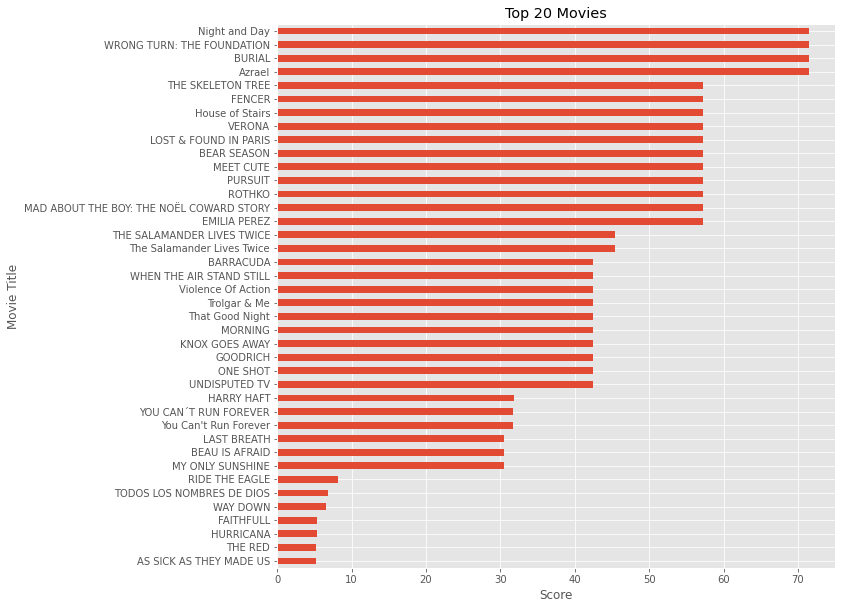

In [8]:
# Average the results of the best five models to predict the 'score' of the 'pred_set' dataframe
best_models = [model_list[i] for i in lgbm_results['rmse'].sort_values().index[:5]]
pred_set['score'] = sum([model.predict(X_pred, num_iteration=model.best_iteration_) for model in best_models]) / len(best_models)

cols2use = ['title', 'score', 'plot_score', 'genre_1', 'genre_2', 'plot']
results = pred_set[cols2use + [col for col in pred_set.columns if 'talent_total_role_score' in col]]
results = results.merge(pred_metadata, on='title')

# Re-arrange the columns of the 'output' dataframe such that the 'ACTOR' column is followed by the 'talent_total_score_ACTOR', the 'PRODUCER' column is followed by the 'talent_total_score_PRODUCER', and so on.
results = results[['title', 'score', 'plot_score', 'genre_1', 'genre_2', 'plot'] + [col for col in results.columns if 'DIRECTOR' in col] + [col for col in results.columns if 'ACTOR' in col] + [col for col in results.columns if 'PRODUCER' in col] + [col for col in results.columns if 'WRITER' in col]]
results.sort_values('score', ascending=False, inplace=True)
# Plot the top 20 movies
results.head(40).plot(x='title', y='score', kind='barh', figsize=(10, 10), legend=False)
plt.gca().invert_yaxis()
plt.xlabel('Score')
plt.ylabel('Movie Title')
plt.title('Top 20 Movies')
plt.show()

Index(['title', 'score', 'plot_score', 'genre_1', 'genre_2', 'plot',
       'talent_total_role_score_DIRECTOR', 'DIRECTOR',
       'talent_total_role_score_ACTOR', 'ACTOR',
       'talent_total_role_score_CO_PRODUCER',
       'talent_total_role_score_EXECUTIVE_PRODUCER',
       'talent_total_role_score_PRODUCER', 'CO_PRODUCER', 'EXECUTIVE_PRODUCER',
       'PRODUCER', 'talent_total_role_score_WRITER', 'WRITER', 'genre'],
      dtype='object')

In [15]:
results.columns = [col.title() for col in results.columns]
results['Title'] = results['Title'].str.title()
results['Genre_1'] = results['Genre_1'].fillna('')
results['Genre_2'] = results['Genre_2'].fillna('')
results['Director'] = results['Director'].str.title().fillna('')
results['Actor'] = results['Actor'].str.title().fillna('')
results['Genre'] = results['Genre_1'].str.title() + ', ' + results['Genre_2'].str.title()
results['Genre'] = results['Genre'].str.rstrip(', ')
results[['Title', 'Score', 'Genre', 'Plot', 'Director', 'Actor']].head(40).to_json('data/predictions.json', orient='records')

In [16]:
results.head(20)

,Title,Score,Plot_Score,Genre_1,Genre_2,Plot,Talent_Total_Role_Score_Director,Director,Talent_Total_Role_Score_Actor,Actor,Talent_Total_Role_Score_Co_Producer,Talent_Total_Role_Score_Executive_Producer,Talent_Total_Role_Score_Producer,Co_Producer,Executive_Producer,Producer,Talent_Total_Role_Score_Writer,Writer,Genre
834,Night And Day,71.432078,45.903887,drama,romance,"Passionate astronomer, Katharine Hilbery does ...",NaN,Tina Gharavi,152.800000,"Haley Bennett, Elyas M'Barek, Timothy Spall, J...",NaN,NaN,NaN,NaN,NaN,"Justine Waddell, Janine Jansen, Christopher Fi...",NaN,Justine Waddell,"Drama, Romance"
56,Wrong Turn: The Foundation,71.432078,3.800010,thriller,action,"New Yorkers Jes, Darius, Milla, Adam, Gary, an...",NaN,Mike P. Nelson,217.000000,"Charlotte Vega, Matthew Modine",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Thriller, Action"
36,Burial,71.432078,4.477028,drama,action,"Set in the last days of WWII, BURIAL tells the...",NaN,Ben Parker,73.666667,"Tom Felton, Charlotte Vega, Harriet Walter, Ba...",NaN,NaN,1.0,NaN,NaN,"J. Paul Higgins, Matthew James Wilkinson, Hugh...",NaN,NaN,"Drama, Action"
692,Azrael,71.432078,4.761191,drama,,"In a world in which no one speaks, a devout fe...",NaN,E. L. Katz,59.000000,"Samara Weaving, Nathan Stewart Jennings, Eero ...",NaN,NaN,NaN,NaN,NaN,"Dan Kagan, Simon Barrett, Dave Caplan",NaN,Simon Barrett,Drama
498,The Skeleton Tree,57.204284,5.913928,action,,Based on the novel by award-winning author Iai...,NaN,Paul Barry,364.000000,"Jacob Tremblay, Woody Norman",NaN,NaN,5.0,NaN,NaN,"Kelly McCormick, Kristian Andresen, Michael Co...",NaN,Paul Barry,Action
46,Fencer,57.204284,5.777474,drama,family,FENCER plunges us into the heart and mind of a...,NaN,,282.000000,Zoe Saldana,NaN,NaN,NaN,NaN,NaN,"Claudia Bluemhuber, Casey Affleck, Whitaker La...",NaN,NaN,"Drama, Family"
777,House Of Stairs,57.204284,0.317496,thriller,scifi,"Set in a dystopian America in the near future,...",NaN,Wi Ding Ho,364.000000,Jacob Tremblay,NaN,NaN,NaN,NaN,NaN,"Michael Solomon, Alexis Perrin, Benoit Roland",NaN,Matthes McInerney-Lacombe,"Thriller, Scifi"
713,Verona,57.204284,12.478494,music,drama,"Currently filming on location in Verona, Italy...",NaN,Timothy Scott Bogart,256.000000,"Rebel Wilson, Rupert Everett, Jason Isaacs, Si...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timothy Scott Bogart,"Music, Drama"
343,Lost & Found In Paris,57.204284,8.712405,drama,comedy,Writer-director Everett will create a film abo...,NaN,Rupert Everett,380.500000,"Kit Clarke, Kristin Scott Thomas, Rupert Evere...",NaN,NaN,1.0,NaN,NaN,Jeremy Thomas,NaN,Rupert Everett,"Drama, Comedy"
229,Bear Season,57.204284,24.866604,drama,,"Izzy, struggling to adapt to life after the wa...",NaN,Simon Aboud,184.000000,"Luke Evans , Jacob Tremblay, Olga Kurylenko",NaN,NaN,NaN,NaN,Colette Aguila,J. Todd Harris,NaN,NaN,Drama


## Feature importances
Analyzing which features most significantly impact the model's predictions.

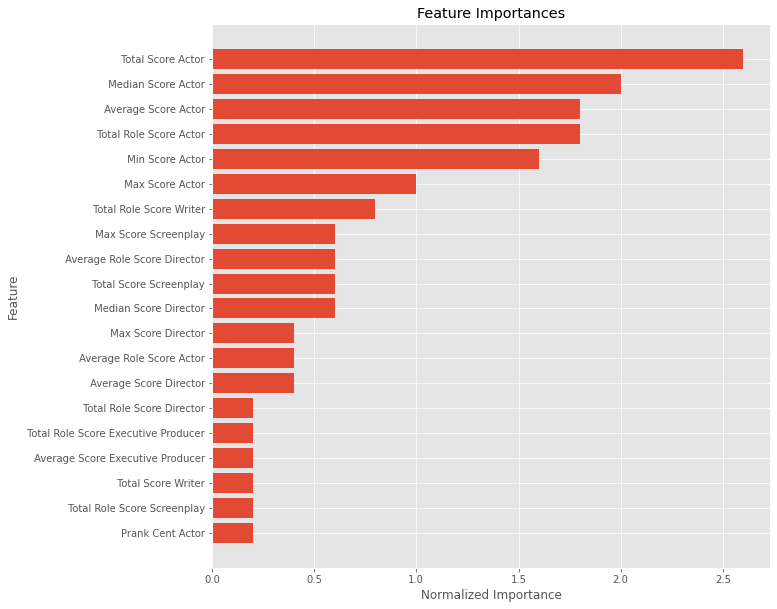

In [20]:
# Average the feature importances of the best five models
feature_importances = pd.DataFrame()
feature_importances['feature'] = [col.replace('_', ' ').replace('talent', '').title() for col in col_names]
feature_importances['importance'] = sum([model.feature_importances_ for model in best_models]) / len(best_models)
feature_importances.sort_values('importance', ascending=False, inplace=True)

# Plot the first 20 feature importances using horizontal bars
plt.figure(figsize=(10, 10))
plt.barh(feature_importances['feature'][:20], feature_importances['importance'][:20])
plt.gca().invert_yaxis()
plt.title('Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.show()

In [22]:
feature_importances.head(20).to_json('data/feature_importances.json', orient='records')